# **EDSA Movie Recommender System**

Table Of Content

Introduction

problem statement

**Index:**



*   Exploratory Data Analysis(EDA)

*   Content based filtering


*   Collaborative Filtering
*   Single Value Decomposition(SVD)



*   Building a model and Kaggle submission
*   Conclussion and References



# **Introduction**



"Hi AI am bored could you please recommend a movie for me"

*How many times have you thought about that when you're want to watch a movie of your choice without having to search until you you give up and go to bed. this one is for you,yes you*

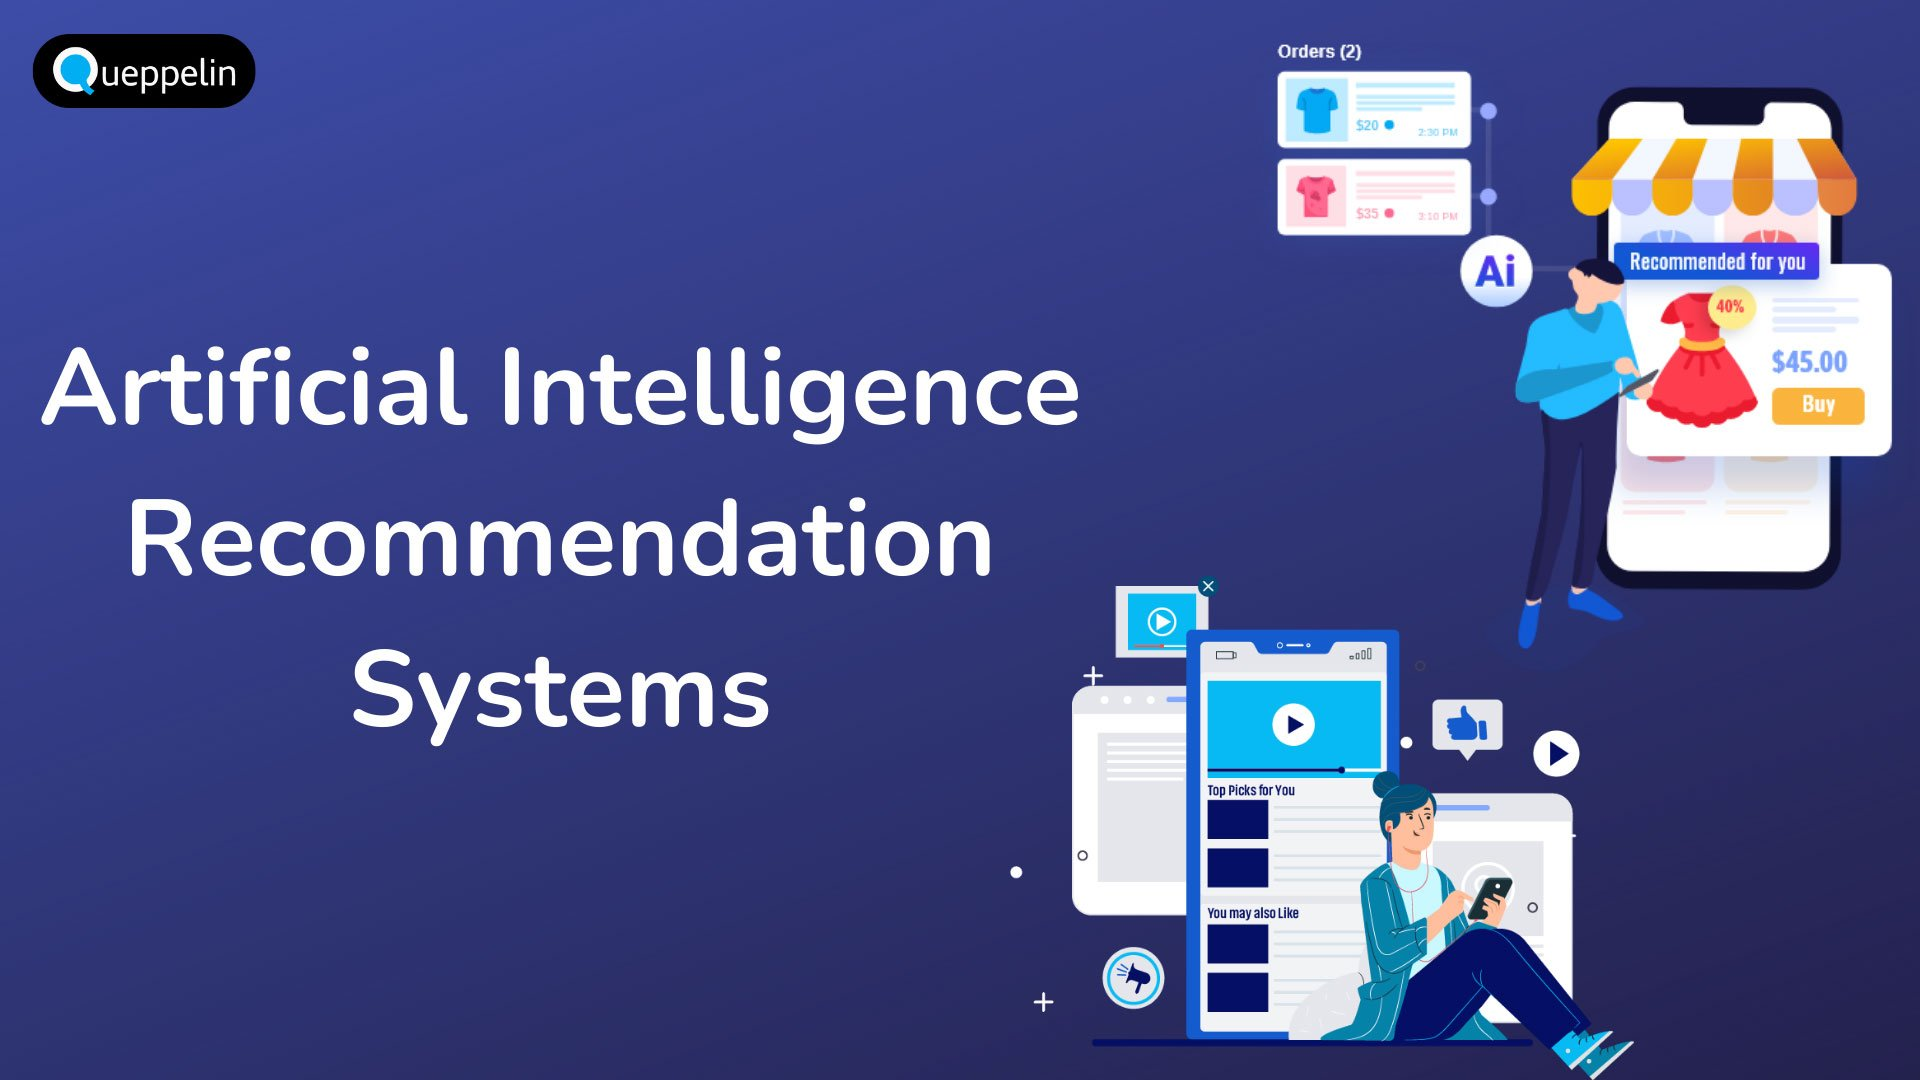

AI and Machine Learning has gone to far in advancing our comfort zone when it is time to relax and feel at home. We Introduce Movie Recommende systems to you.

You might be asking yourself, what is a Movie recommender system, Well I have got your back buddy:


Recommender System is a system that seeks to predict or filter preferences according to the user's choices. Netflix, YouTube, Tinder, and Amazon are all examples of recommender systems in use. The systems entice users with relevant suggestions based on the choices they make.

Further explaination: Recommendation System is a filtration program whose prime goal is to predict the “rating” or “preference” of a user towards a domain-specific item or item. In our case, this domain-specific item is a movie, therefore the main focus of our recommendation system is to filter and predict only those movies which a user would prefer given some data about the user him or herself.


We Have two types of different filtering to recommend movies for you:

1. Content Based Filtering
2. Collaborative Filtering

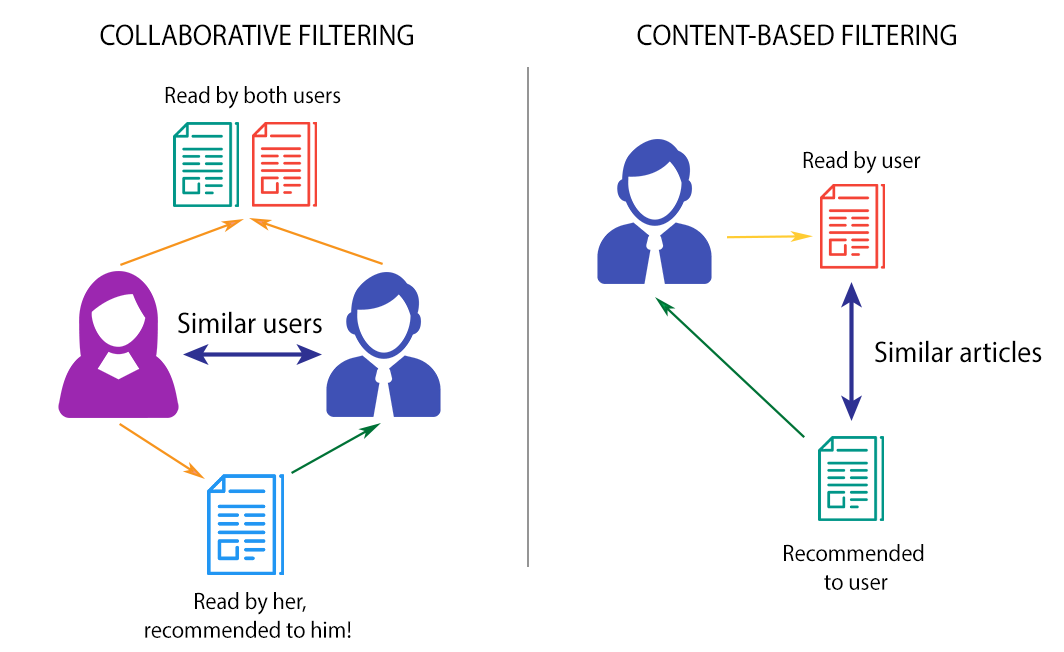

*See, I told you I got you*


# **Problem Statement **

We are task to construct a recommendation algorithm based on Content or Collaborative Filtering, which is capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences or choices.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 20.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630162 sha256=e3688781662198b8c49a7eeb4e698698c02cb6f6e28c52ff82aafe6c9bebf478
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from sklearn.neighbors import  NearestNeighbors
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Packages for Randomisation
import random


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [4]:
# Import Libraries
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [5]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")
dftest = pd.read_csv("/content/drive/MyDrive/test.csv")
#tags = pd.read_csv("/content/drive/MyDrive/tags.csv")
movies = pd.read_csv("/content/drive/MyDrive/movies.csv")
#links = pd.read_csv("/content/drive/MyDrive/links.csv")
imdb = pd.read_csv("/content/drive/MyDrive/imdb_data.csv")
#genome_tags = pd.read_csv("/content/drive/MyDrive/genome_tags.csv")
#genome_scores = pd.read_csv("/content/drive/MyDrive/genome_scores.csv")

In [6]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [7]:
dftest.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [12]:
imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
import pickle
import copy
import random
from surprise import Reader, Dataset
from surprise import SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

## **Exploratory Data Analysis (EDA)**

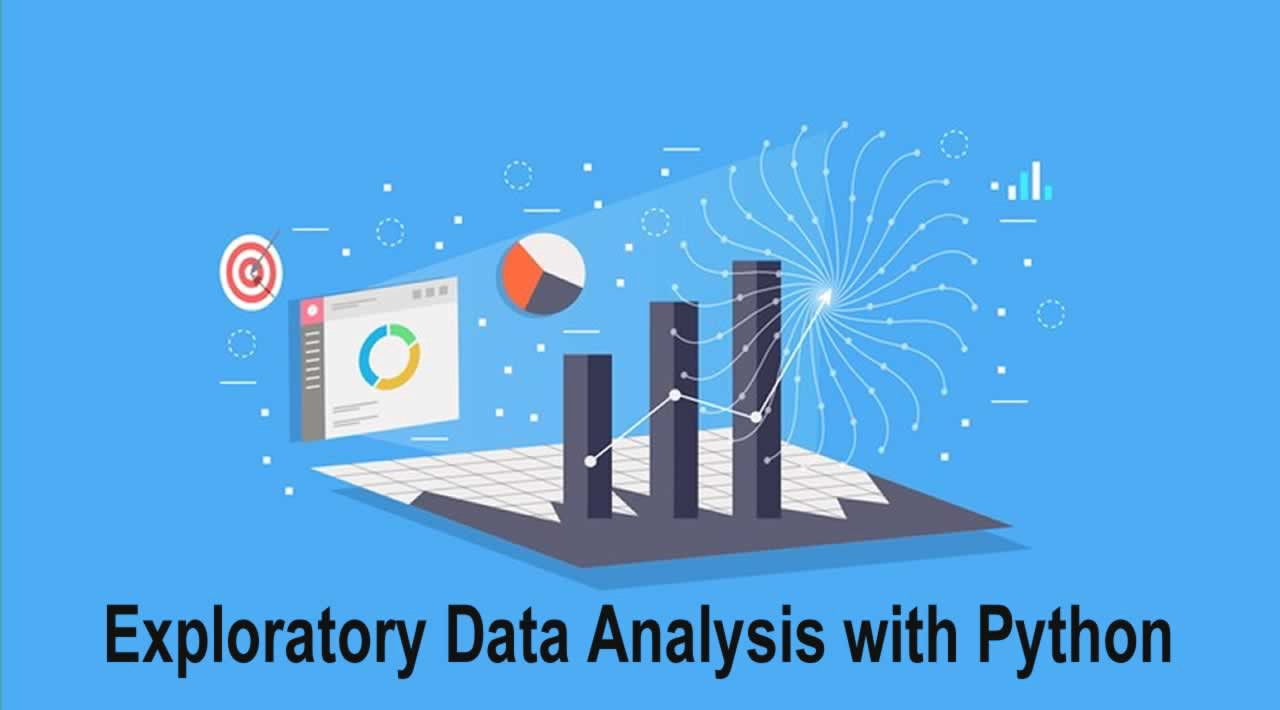

**The Most Populated Genres Movies ever released**

<BarContainer object of 19 artists>

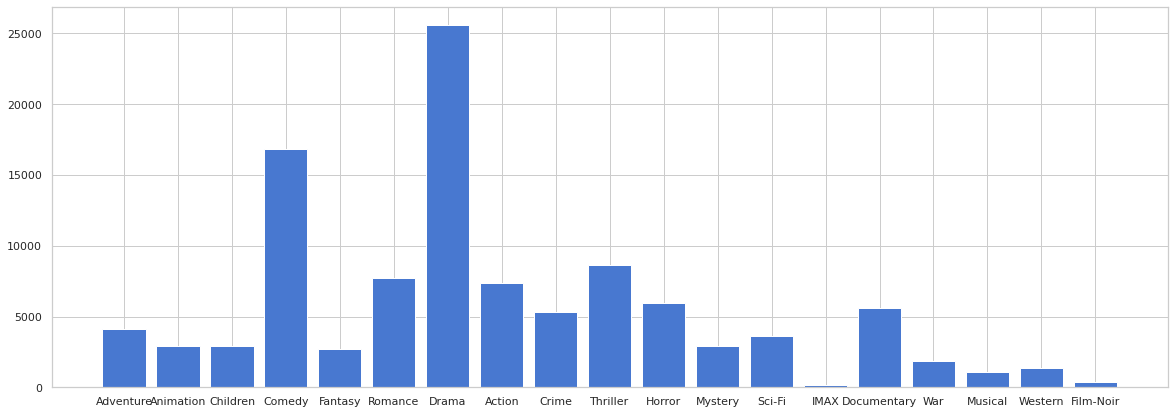

In [16]:
plt.figure(figsize=(20,7))
generlist = movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='b')

Based on the visualised, we can see that the most popular genre is Drama followed by Comedy and Thriler

**Users ratings distribution**

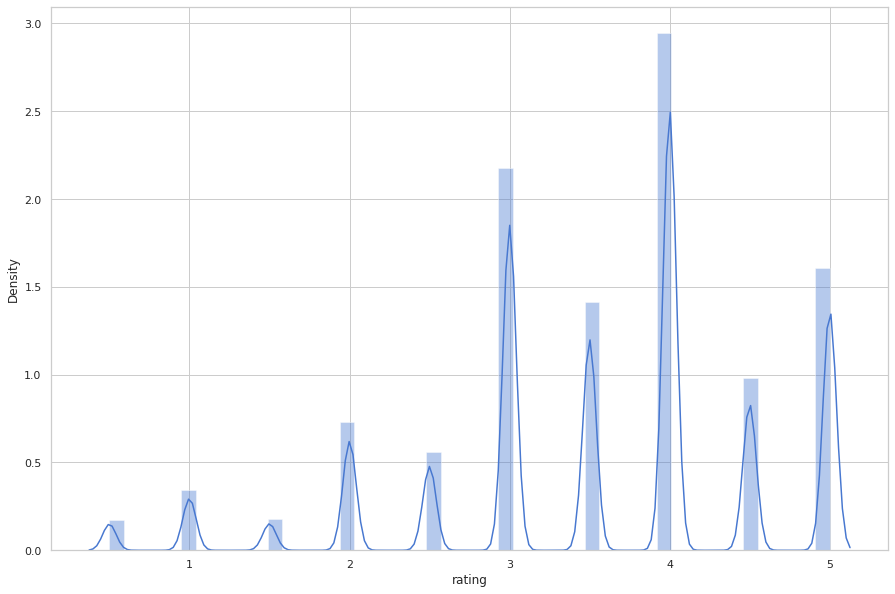

In [17]:
sns.distplot(train["rating"]);

We can tell that from our right skewed ratings graph that most users rates movies by 4 followed by 3 and 5.

In [18]:
((train.shape),(movies.shape))

((10000038, 4), (62423, 3))

In [19]:
#Merge movies and train tables
df = pd.merge(movies, train , on = 'movieId', how='inner')
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,158849,5.0,994716786
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,97203,5.0,942683155
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,161871,3.0,833104576
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,45117,4.0,1442256969
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,27431,5.0,849667827


In [21]:
merge_ratings_movies = df.drop('timestamp', axis=1)
merge_ratings_movies.shape

(10000038, 5)

In [22]:
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])
ratings_grouped_by_users.head(2)

movieId              rating          
          size         mean   size      mean
userId                                      
1           28  6031.892857     28  3.910714
2           72  4658.722222     72  3.416667

In [23]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

Top 10 users who have rated most of the movies

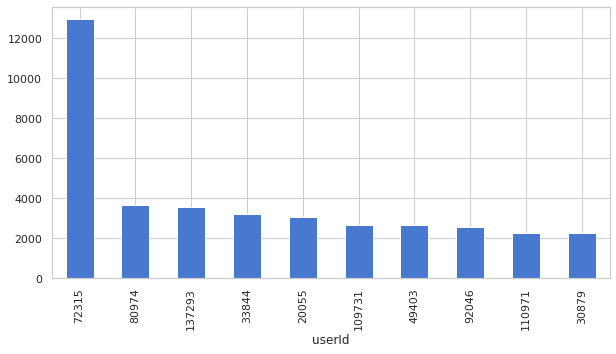

In [25]:
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind='bar', figsize = (10,5))

Analyzing Number of Movies Produced Annually

In [ ]:
# Create dataframe containing only the movieId and genres
movies_year = pd.DataFrame(movies[['movieId', 'title']],columns=['movieId', 'title'])

movies_year= movies_year[movies_year['title'].notnull()]
# Split the year from title
movies_year.title = movies_year.title.apply(lambda x: x[-5:-1])

movies_year = movies_year.groupby(['title'])['movieId'].count().reset_index(name="count")
movies_year =movies_year[movies_year['count'] > 500]
movies_year =movies_year.sort_values(by='count',ascending=True)

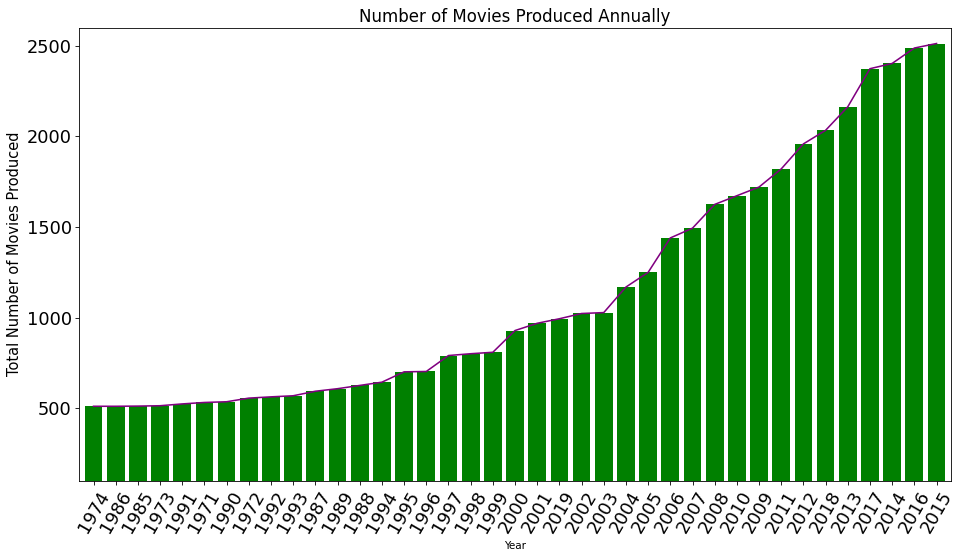

In [ ]:
y_labels =movies_year['count']

# Plot the figure.
fig,ax = plt.subplots(figsize=(15, 8), dpi = 75)

movies_year[['count', 'title']].plot(x='title',kind='bar', color='green', fontsize=17, ylim=[100, 2600],
                                           width=.8, ax=ax, legend=False)
                                     
movies_year.plot(x='title', kind = 'line', ax=ax, color='purple', legend=False)
                                     
ax.set_title('Number of Movies Produced Annually', fontsize=16)
ax.set_xlabel('Year')
ax.set_ylabel('Total Number of Movies Produced', fontsize=14)
                                     
plt.xticks(rotation=60)
plt.show()

from the above graph we can see that each and every year, the number of movies increases compare to previous years.

***Due to space limitations: Content-Based Filtering and Collaborative Filtering recommender system built in other notebooks***

# **Building Kaggle Submission Model**

In [ ]:
from surprise import Reader
from surprise import Dataset

from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy 

In [ ]:
#Preparing the dataset
train_set = train.drop(['timestamp'], axis=1)
train_set = train_set.reset_index(drop=True)

print(train_set.shape)
train_set.head()

(10000038, 3)


,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


# Singular Value Decomposition (SVD)

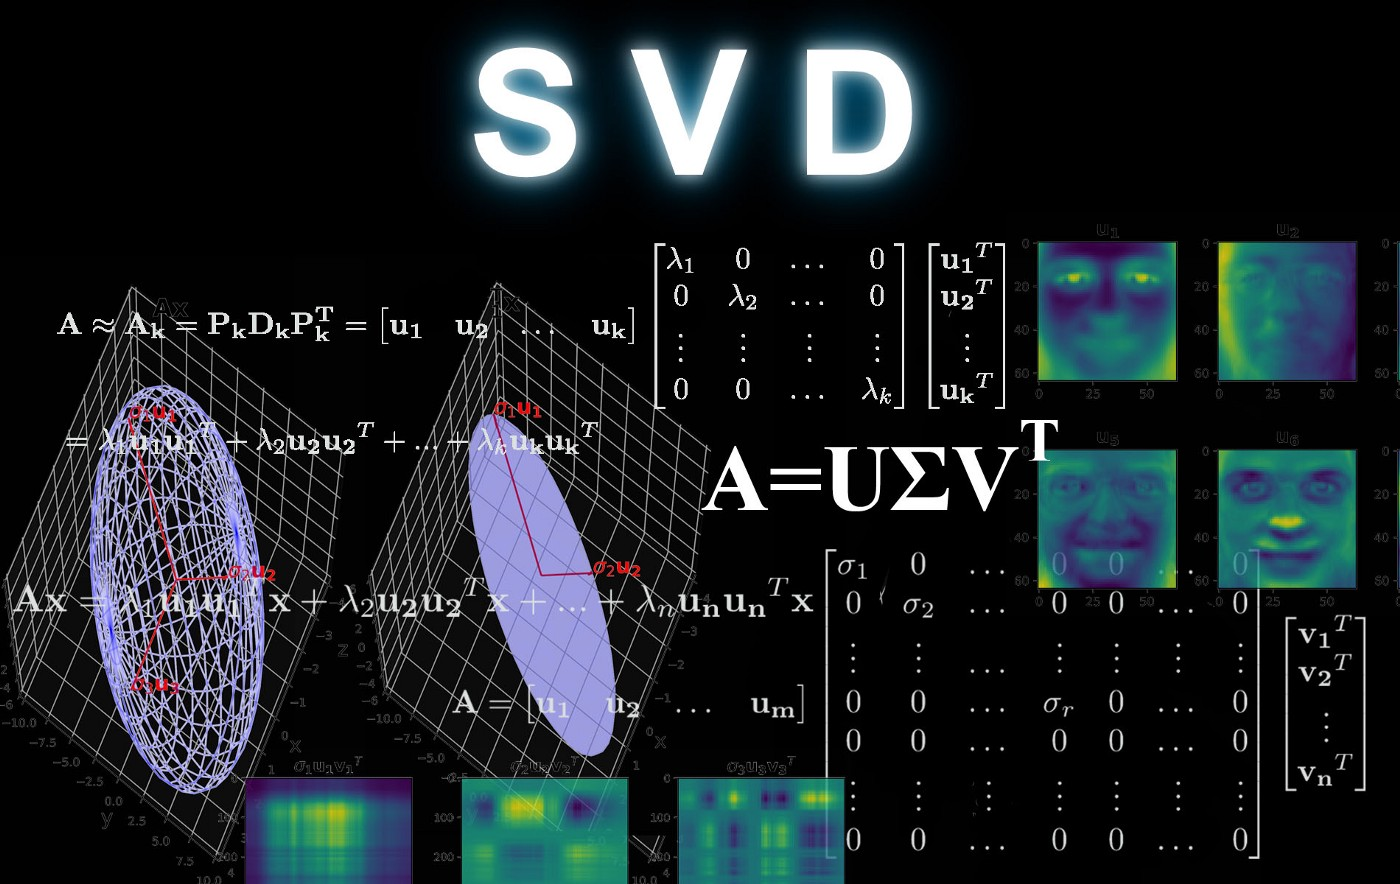

The Singular Value Decomposition (SVD) of a matrix is a factorization of that matrix into three matrices. It has some interesting algebraic properties and conveys important geometrical and theoretical insights about linear transformations. It also has some important applications in data science.

we will use the Surprise library that provided various ready-to-use powerful prediction algorithms including (SVD) to evaluate its RMSE (Root Mean Squared Error) on the MovieLens dataset. It is a Python scikit building and analyzing recommender systems.


In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

#our training data

new_train = train.head(500000)
df = pd.DataFrame(new_train)
del df['timestamp']


# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [ ]:
#packages we need
from surprise import accuracy
from surprise.model_selection import train_test_split

#allows us to train on the whole dataset
trainset = data.build_full_trainset()

#SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)

In [ ]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the SVD algorithm.
algo2 = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo2.fit(trainset)
predictions = algo2.test(testset)

# Compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9327


0.9326949595620898

We get a mean Root Mean Square Error of 0.93 which is pretty good. Let's now train on the dataset and arrive at predictions.

# Conclusion

We implemented and evaluated different widely used Movie Recommendation models. Also, we developed our own models Collaborative and SVD. We evaluated each model with the appropriate evaluation metric. We implemented novel technique to evaluate collaborative filtering algorithm by using SVD and hit ratio as a metric

We attempted to build a model-based Collaborative Filtering movie recommendation sytem based on latent features from a low rank matrix factorization method called SVD

We could not build other models due to the limitation of space in our Machine.

**Submission**

In [ ]:
dftest.loc[:, 'rating'] = 0
dftest.head()

,userId,movieId,rating
0,1,2011,0
1,1,4144,0
2,1,5767,0
3,1,6711,0
4,1,7318,0


In [ ]:
#using load_from_df surprise function to load dataset for predictions
test_processed = Dataset.load_from_df(dftest[['userId','movieId','rating']], reader)

#Train test split, test size will be equal to 1.
NA, test = train_test_split(test_processed, test_size=1.0, shuffle = False, random_state = 42)

#Prediction 
predictions = algo.test(test)

In [ ]:
#saving the predictions as a list to add as a column for our Kaggle submission
ratings = [i.est for i in predictions]
ratings

[3.3812355816163415,
 3.913213294969797,
 3.0776714662545963,
 3.768405995148366,
 3.2441489331841966,
 3.8659994782660876,
 3.6583989792701908,
 4.217799264658549,
 4.041367680383607,
 4.023311451804271,
 3.7954156465681135,
 3.5964058970320276,
 3.699869346291797,
 4.309293404767155,
 3.9976363753236757,
 4.0495053922196025,
 4.0054206573357565,
 3.6109510588748583,
 3.537642047881939,
 3.631611117208318,
 4.196158589962855,
 3.554243495179679,
 3.566685507732615,
 3.1369003032749836,
 3.7310859339733797,
 3.7709256740107038,
 3.976079989506628,
 3.475942042986277,
 3.1882354726929716,
 3.928593191101492,
 3.885216955700428,
 3.814021640061106,
 3.471644445973549,
 3.0025464279216725,
 2.92462085729853,
 3.4169246588235604,
 3.5616490811655526,
 3.935405137269928,
 3.918443638861783,
 3.6178579869950136,
 3.8456636884029707,
 3.6775970105030384,
 3.88082895296654,
 3.4397828323679227,
 3.485707277444254,
 4.195101739270444,
 4.359067701395089,
 4.514659667437725,
 4.302667073695238,


In [ ]:
dftest['Id'] = dftest['userId'].astype(str)  +'_'+ dftest['movieId'].astype(str)

In [ ]:
dftest

,userId,movieId,rating,Id
0,1,2011,0,1_2011
1,1,4144,0,1_4144
2,1,5767,0,1_5767
3,1,6711,0,1_6711
4,1,7318,0,1_7318
...,...,...,...,...
5000014,162541,4079,0,162541_4079
5000015,162541,4467,0,162541_4467
5000016,162541,4980,0,162541_4980
5000017,162541,5689,0,162541_5689


In [ ]:
#change rating column
dftest['rating'] = ratings
del dftest['userId']
del dftest['movieId']

In [ ]:
dftest

,rating,Id
0,3.381236,1_2011
1,3.913213,1_4144
2,3.077671,1_5767
3,3.768406,1_6711
4,3.244149,1_7318
...,...,...
5000014,3.200280,162541_4079
5000015,3.554763,162541_4467
5000016,3.210533,162541_4980
5000017,3.215571,162541_5689


In [ ]:
dftest['new'] = dftest['rating']
del dftest['rating']

In [ ]:
dftest['rating'] = dftest['new']

In [ ]:
del dftest['new']

In [ ]:
dftest

,Id,rating
0,1_2011,3.381236
1,1_4144,3.913213
2,1_5767,3.077671
3,1_6711,3.768406
4,1_7318,3.244149
...,...,...
5000014,162541_4079,3.200280
5000015,162541_4467,3.554763
5000016,162541_4980,3.210533
5000017,162541_5689,3.215571


In [ ]:
#dftest.to_csv('C:/Users/Nontsizi Congwane/Downloads/submission.csv', index = False)

from google.colab import files
dftest.to_csv('submission.csv',index = False) 
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **... END ...**